# Heart Attack Prediction

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from scipy.stats import entropy

# load the dataset
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# Functions

In [2]:
def run_all_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    models = {
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    return pd.DataFrame(model_performance)

def automate_pca(pca_components, X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_test_pca = pca.transform(X_test_scaled)
  
  models = run_all_models(X_train_pca, X_test_pca, y_train_encoded, y_test_encoded)
  print(models)
  
def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): _description_

  Returns:
      pd.DataFrame: _description_
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

In [3]:
df = pd.read_csv("heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [5]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
df.duplicated().sum()

1

In [7]:
df.drop_duplicates(inplace=True)

# Check for target column balance

In [8]:
target = df.values[:,-1]
counter = Counter(target)

for k, v in counter.items():
  per = v/len(target) * 100
  print("Class=%d, Count=%d, Percentage=%.3f%%" % (k,v,per))

Class=1, Count=164, Percentage=54.305%
Class=0, Count=138, Percentage=45.695%


In [9]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [10]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [11]:
calculate_entropy(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
entropy,5.071425,0.902062,1.739216,4.697744,7.043965,0.607349,1.088236,6.171413,0.912678,4.136481,1.294646,1.651399,1.2969,0.994647


In [12]:
df["sex"].value_counts()

sex
1    206
0     96
Name: count, dtype: int64

# Distribution Shape

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/3075930875.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/3075930875.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/3075930875.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/3075930875.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/3075930875.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/3075930875.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/30759

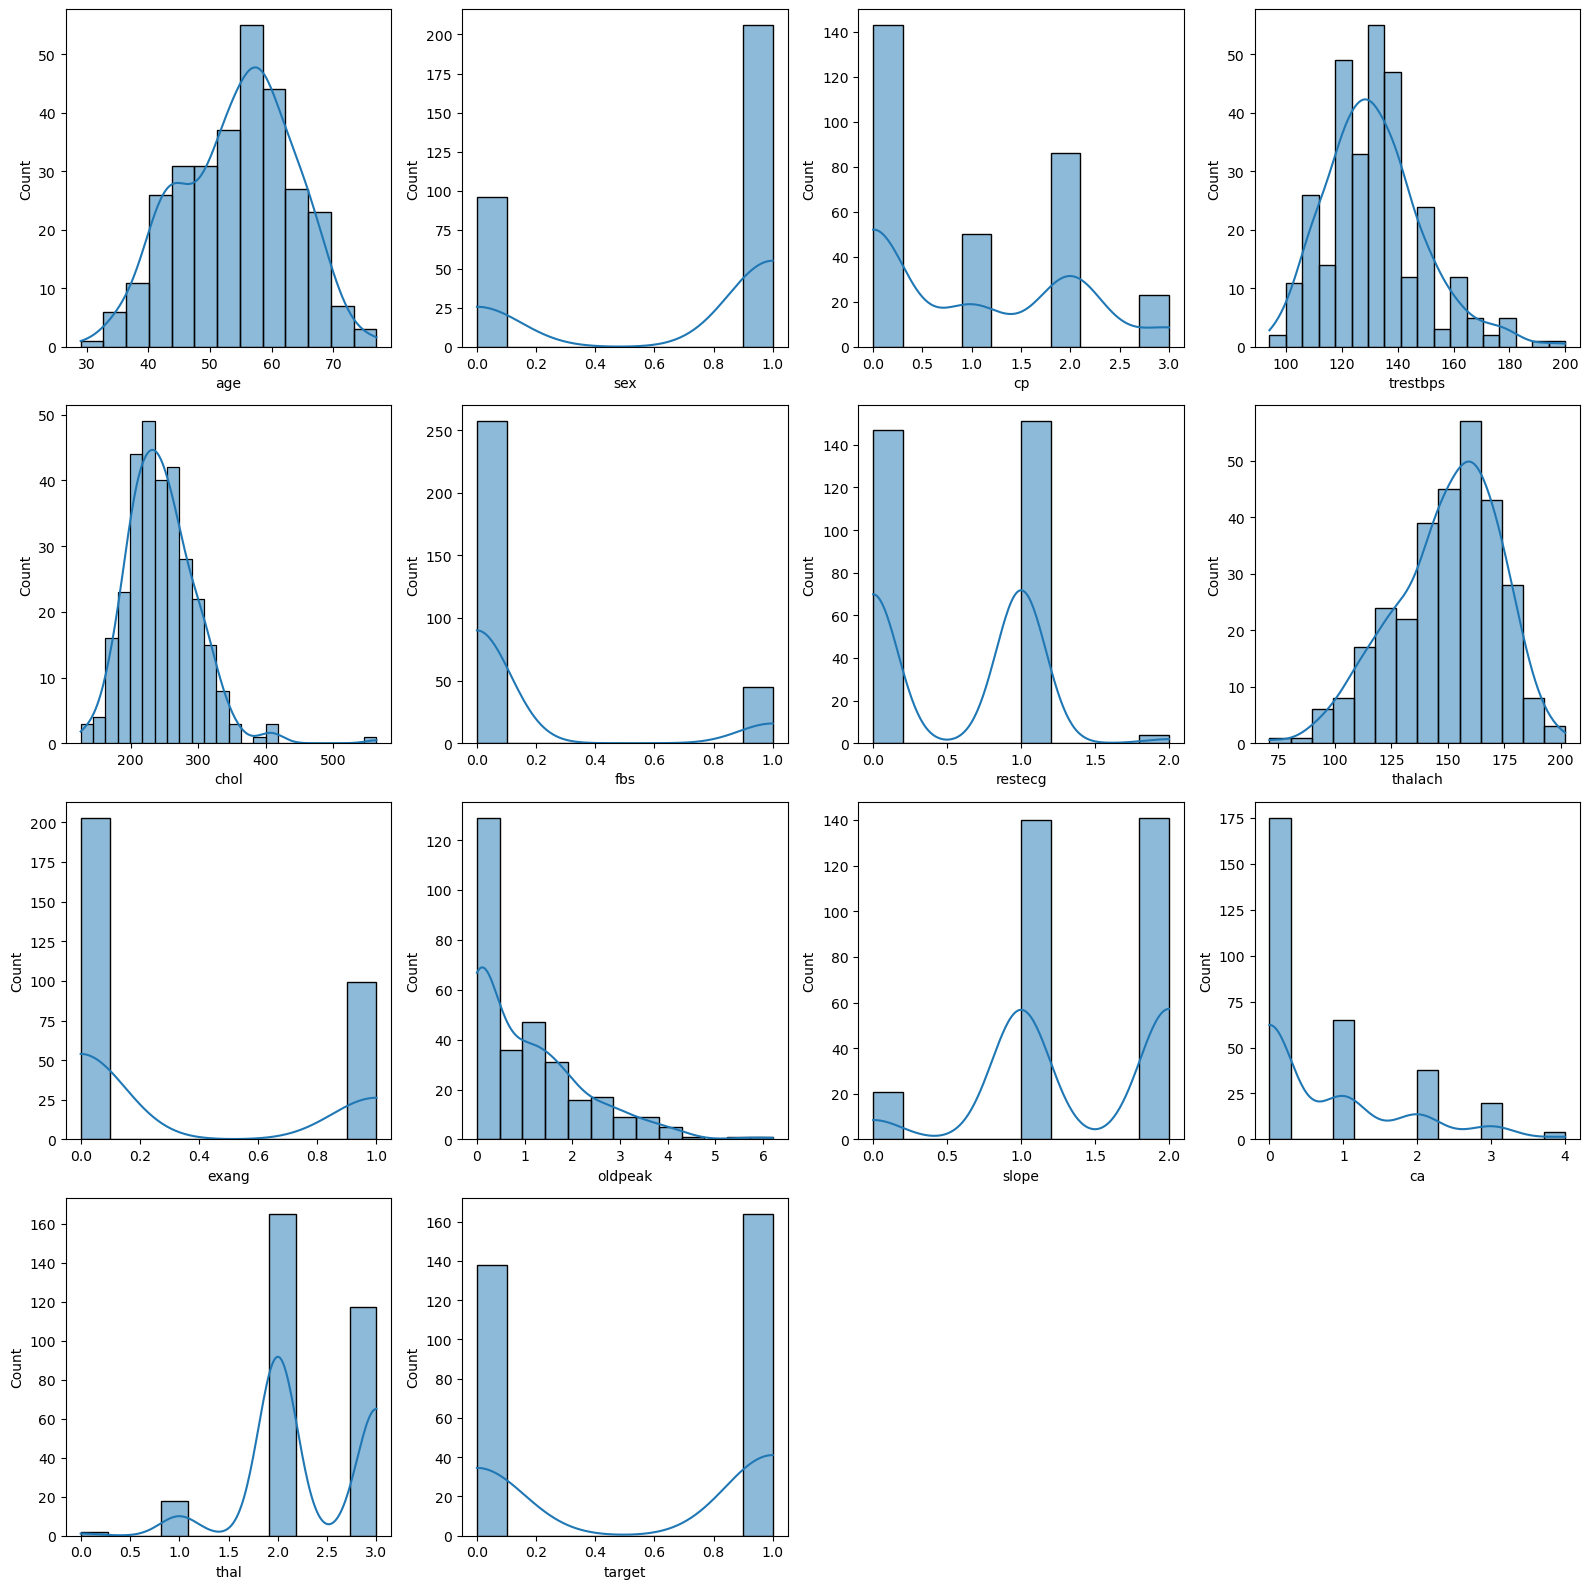

In [13]:
col_values = len(df.columns)
rows = (col_values+3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.tight_layout()
  plt.plot()

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/2779620965.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/2779620965.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/2779620965.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/2779620965.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/2779620965.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/2779620965.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_91695/27796

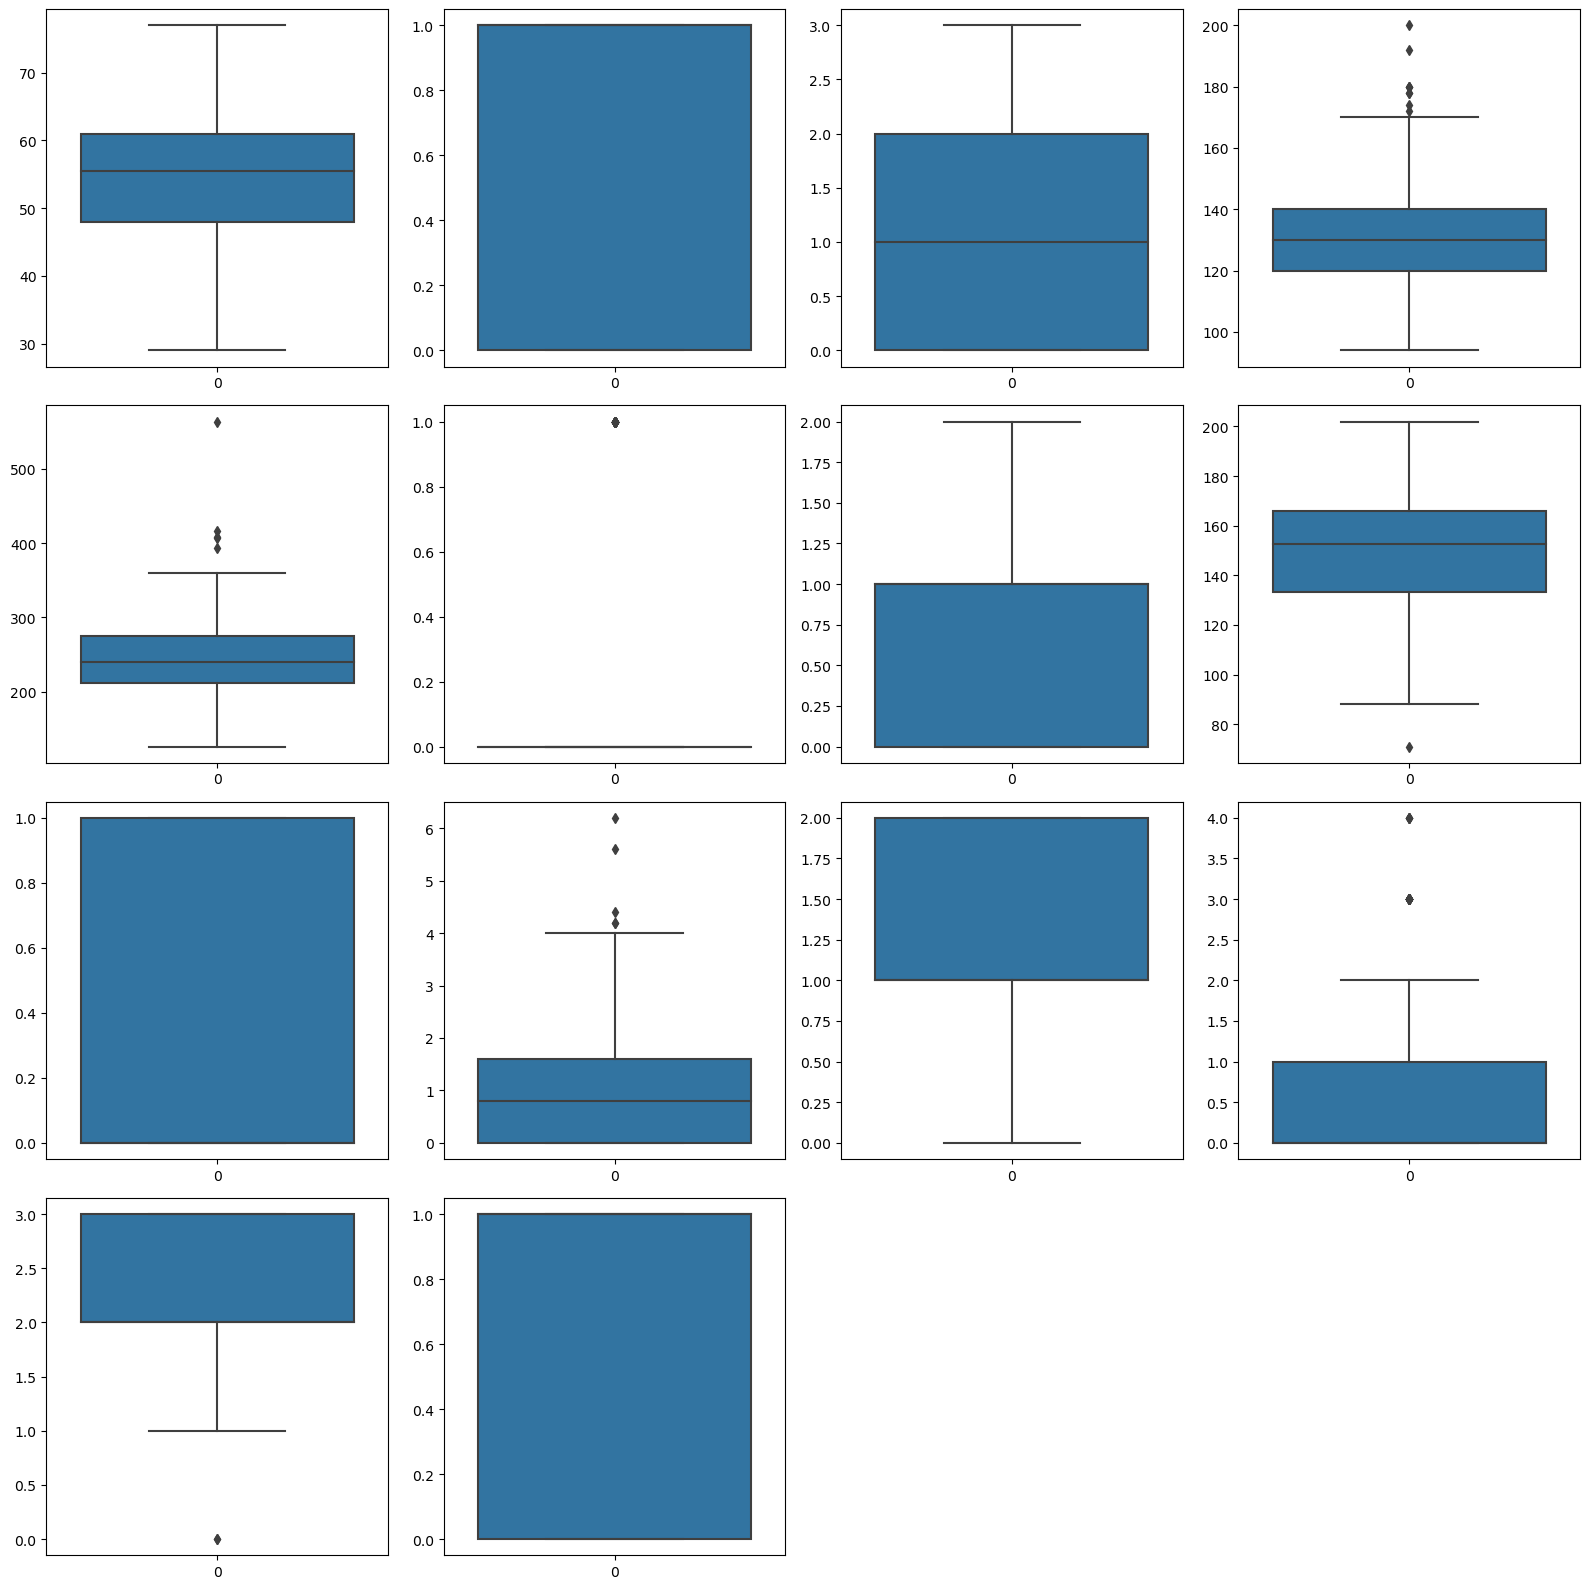

In [14]:
col_values = len(df.columns)
rows = (col_values+3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.boxplot(df[col])
  plt.tight_layout()
  plt.plot()

<Axes: >

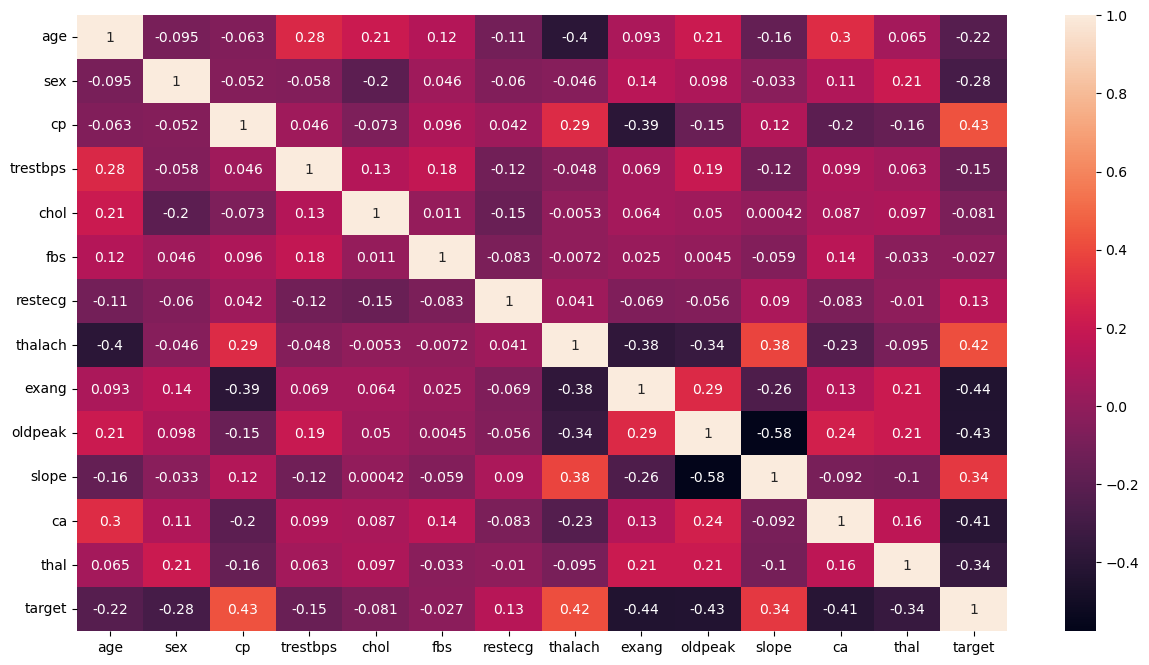

In [15]:
plt.figure(figsize=(15,8))
relations = df.corr()
sns.heatmap(data=relations, annot=True)

# Model Evaluation